![](brain.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plot

# Validation du gradient
## Mise en situation
Je suis en train de mettre en place des systèmes de plus en plus complexes, avec des fonctions d'activations différentes, et plein de dérivées dans tous les sens.

J'aimerais m'assurer que les dérivées sont bien correctes... Je m'y perds.

## Un outil de debug
Ce qu'on va voir aujourd'hui n'est pas un outil de développement de réseau de neurone. C'est plutôt un outil de debug pour essayer de valider que les descentes de gradient suivent les directions correctes.

En tant qu'outil de debug, il convient de ne pas le laisser actif en production :) Et c'est un outil assez couteux aussi. Il ne doit être utilisé que pour valider une implémentation de calcul de gradient, et désactivé ensuite..

### Le principe
Le gradient que l'on calcule est la dérivée du coût au point considéré, c'est-à-dire la direction de la tangente. En 2D, ça ressemble à ça:

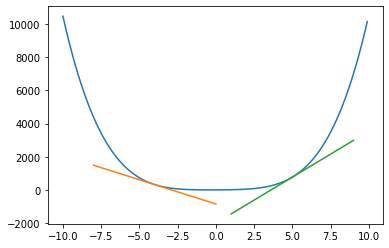

In [2]:
def f(x): return x**4 + 5*x**2 + 4*x + 7
def df(x): return 4*x**3 + 10*x + 4

x = np.arange(-10, 10, .1)
plot.plot(x, f(x))
for z in [-4, 5]:
    plot.plot([z-4, z+4], [f(z)-4*df(z), f(z)+4*df(z)])

La fonction $f'(x) = 4x^3 + 10x + 4$ est la dérivée exacte de $f$.

Une définition formelle de la dérivée est

$f'(x) = \displaystyle\lim_{h\to0}{\frac{f(x+h)-f(x)}{h}}$

C'est la "dérivée droite", puisqu'on la calcule par la droite du point $x$. On peut calculer la "dérivée gauche" en prenant $f(x)-f(x-h)$ ou encore calculer la dérivée des deux côtés : 

$f'(x) = \displaystyle\lim_{h\to0}{\frac{f(x+h)-f(x-h)}{2h}}$

En gros, on calcule le coefficient directeur d'une droite qui passerait par $(x, f(x))$ et un autre point juste à côté - le plus près possible.

f'(5) ~= 634.0
f'(5) == 554


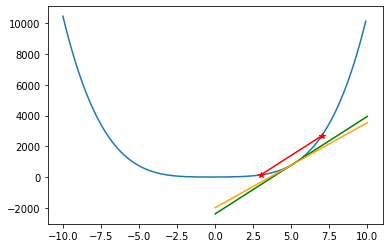

In [3]:
x = np.arange(-10, 10, .1)
plot.plot(x, f(x))
z=5
plot.plot([z-2, z+2], [f(z-2), f(z+2)], "r*-")

delta = (f(z+2)-f(z-2))/4
plot.plot([z-5, z+5], [f(z)-5*delta, f(z)+5*delta], "g-")
plot.plot([z-5, z+5], [f(z)-5*df(5), f(z)+5*df(5)], color='orange')


print("f'(5) ~= " + str(delta))
print("f'(5) == " + str(df(5)))

Donc
* en rouge, la corde qui passe par deux points autour de 5.
* en vert, la pseudo tangente, parallèle à la corde, en 5.
* en orange, la vraie tangente, en 5.

C'est pas parfait, mais c'est une bonne approximation. Et encore, là, l'écart autour du point est de +/-2. C'est énorme, en pratique quand on dit "petit", c'est plutôt $10^{-7}$ par exemple.

In [4]:
epsilon = 1e-7
delta = (f(5+epsilon)-f(5-epsilon))/2/epsilon
print('Approximation : %f, exact : %f' % (delta, df(5)))
print('Error: %f' % (delta -df(5)))


Approximation : 554.000002, exact : 554.000000
Error: 0.000002


### Application du principe
On sait calculer le coût en fonction de paramètres. L'idée est tout simplement de faire varier un seul de ces paramètes de manière infime, et de regarder l'évolution du coût. _Normalement_, on doit avoir grosso modo la même chose que la dérivée en ce point, qui correspond au gradient pour ce paramètre.

### Pourquoi faire une dérivée
La question qui se pose, puisque cette méthode est plus sûre que la dérivée (on s'en sert pour valider une autre implémentation), est de savoir pourquoi garder la dérivée et tous ces calculs un peu pénibles.

La réponse est que le calcul de cette approximation prend beaucoup plus de temps que de calculer la dérivée. Pour cette même raison, on ne fera pas d'entraînement complet avec ce mécanisme actif...

## Retour à la mise en situation
On va reprendre notre réseau avec une couche intermédiaire et les trois fonctions d'activation.

In [5]:
def sigmoid(x) : return 1 / (1 + np.exp(-x))
def tanh(x): return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))
def relu(x): return np.maximum(x, 0)

def forward_pass(X, W, b, activation):
    Z = np.dot(W, X) + b
    if activation == 'sigmoid':
        A = sigmoid(Z)
    elif activation == 'tanh':
        A = tanh(Z)
    elif activation == 'relu':
        A = relu(Z)
    return Z, A

def whole_forward_pass(X, Y, W1, b1, W2, b2, first_layer_activation):
    Z1, A1 = forward_pass(X,  W1, b1, activation = first_layer_activation)
    Z2, A2 = forward_pass(A1, W2, b2, activation = 'sigmoid')
    cost = np.squeeze(-np.sum(np.log(A2) * Y + np.log(1 - A2) * (1-Y))/X.shape[1])
    return Z1, Z2, A1, A2, cost

def backward_pass(dA, A, Z, A_prev, W, activation):
    # Note: on pourrait ne passer que Z, A vaut sigmoid, tanh ou relu de Z, mais bon gagnons du temps de calcul...
    if activation == 'sigmoid':
        dZ = dA * A * (1 - A)
    elif activation == 'tanh':
        dZ = dA * (1 - A**2)
    elif activation == 'relu':
        dZ = dA * np.maximum(Z, 0)

    dW = np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dZ, dW, db, dA_prev

def double_layer_model(X, Y, mid_layer, class_count, learning_rate = 0.0075, num_iterations = 3000,
                       batch_size = 64, first_layer_activation = 'sigmoid', random_range = 1, debug = False):
    m = X.shape[1]
    batchStart = 0
    costs = []

    W1 = np.random.rand(mid_layer, X.shape[0]) * random_range
    b1 = np.zeros((mid_layer, 1))
    W2 = np.random.rand(class_count, mid_layer) * random_range
    b2 = np.zeros((class_count, 1))
    
    for i in range(1, num_iterations+1):
        Xbatch = X[:,batchStart:batchStart + batch_size]
        Ybatch = Y[:,batchStart:batchStart + batch_size]
        
        # Passe en avant
        Z1, Z2, A1, A2, cost = whole_forward_pass(Xbatch, Ybatch, W1, b1, W2, b2, first_layer_activation)
        
        if (i+1) % 10 == 0:
            costs.append(cost)

        dA2 = -(np.divide(Ybatch, A2) - np.divide(1 - Ybatch, 1 - A2))/Xbatch.shape[1]

        dZ2, dW2, db2, dA1 = backward_pass(dA2, A2, Z2, A1,     W2, activation = 'sigmoid')
        dZ1, dW1, db1, dX  = backward_pass(dA1, A1, Z1, Xbatch, W1, activation = first_layer_activation)

        if debug:
            left  = {'W1': np.array(W1, copy=True),
                     'b1': np.array(b1, copy=True),
                     'W2': np.array(W2, copy=True),
                     'b2': np.array(b2, copy=True)}
            right = {'W1': np.array(W1, copy=True),
                     'b1': np.array(b1, copy=True),
                     'W2': np.array(W2, copy=True),
                     'b2': np.array(b2, copy=True)}
            grads = {'W1': dW1,
                     'b1': db1, 
                     'W2': dW2,
                     'b2': db2}
            epsilon = 1e-7
            threshold = 1e-8
            
            for param in ['W1', 'b1', 'W2', 'b2']:
                for row in range(left[param].shape[0]):
                    for col in range(left[param].shape[1]):
                        left [param][row, col] -= epsilon
                        right[param][row, col] += epsilon

                        Z1_left , Z2_left , A1_left , A2_left , cost_left  = whole_forward_pass(Xbatch, Ybatch,  left['W1'],  left['b1'],  left['W2'] ,  left['b2'], first_layer_activation)
                        Z1_right, Z2_right, A1_right, A2_right, cost_right = whole_forward_pass(Xbatch, Ybatch, right['W1'], right['b1'], right['W2'] , right['b2'], first_layer_activation)
                    
                        approx = (cost_right - cost_left) / 2 / epsilon
                        error = np.abs(approx - grads[param][row, col])
                        if error > threshold :
                            print('d%s[%i,%i]: error %s' % (param, row, col, error))
                    
                        left [param][row, col] += epsilon
                        right[param][row, col] -= epsilon

        W1 -= learning_rate * dW1
        b1 -= learning_rate * db1
        W2 -= learning_rate * dW2
        b2 -= learning_rate * db2

        batchStart += batch_size
        if batchStart >= X.shape[1]:
            batchStart = 0
        
    return W1, b1, W2, b2, costs

def model(X, W1, b1, W2, b2, first_layer_activation = 'sigmoid') :
    Z1, A1 = forward_pass(X, W1, b1, activation = first_layer_activation)
    Z2, A2 = forward_pass(A1, W2, b2, activation='sigmoid')
    return A2

In [6]:
x = np.array([[0,0],[0,1],[1,0],[1,1]])
y = np.array([[0,1,1,0]])

x_norm = (x - x.mean(axis=0))/(1e-9 + x.std(axis = 0))
x_norm = x_norm.T

def simulation(activation) :
    np.random.seed(1)
    print('Activation: ' + activation)
    W1, b1, W2, b2, costs = double_layer_model(x_norm, y, 2,1, learning_rate = 1, 
                    num_iterations = 10, first_layer_activation = activation, debug = True)

acts = ['sigmoid', 'tanh', 'relu']
for i in acts:
    simulation(i)

Activation: sigmoid
Activation: tanh
Activation: relu
dW1[0,0]: error 0.009553759081618741
dW1[0,1]: error 0.015082221024459538
dW1[1,0]: error 0.01659580038025486
dW1[1,1]: error 0.0010707528303343465
db1[0,0]: error 0.01508222105951484
db1[1,0]: error 0.0010707528293985307
dW1[0,0]: error 0.0021228524058327525
dW1[0,1]: error 0.0026382687570270266
dW1[1,0]: error 0.015320417037704002
dW1[1,1]: error 0.00037132454642140305
db1[0,0]: error 0.0026382687624972767
db1[1,0]: error 0.00037132454654529266
dW1[0,0]: error 0.0058851002830049275
dW1[0,1]: error 0.007005748145243157
dW1[1,0]: error 0.015133210551501016
dW1[1,1]: error 1.88260719683145e-05
db1[0,0]: error 0.00700574815850746
db1[1,0]: error 1.8826071102784683e-05
dW1[0,0]: error 0.01293757902515474
dW1[0,1]: error 0.016292994827989904
dW1[1,0]: error 0.015639831889483646
dW1[1,1]: error 0.000324012278140313
db1[0,0]: error 0.016292994856640115
db1[1,0]: error 0.00032401227655756877
dW1[0,0]: error 0.01849203648738608
dW1[0,1]: er

On remarque clairement un problème avec le ReLU ! Toute la première couche est fausse (bon ok c'est fait exprès...)

```
dZ = dA * np.maximum(Z, 0)
```

dZ vaut normalement dA si Z > 0 et 0 sinon. Or, là on a **dA fois Z** si Z est positif. On corrige, et on relance :

In [7]:
def backward_pass(dA, A, Z, A_prev, W, activation):
    # Note: on pourrait ne passer que Z, A vaut sigmoid, tanh ou relu de Z, mais bon gagnons du temps de calcul...
    if activation == 'sigmoid':
        dZ = dA * A * (1 - A)
    elif activation == 'tanh':
        dZ = dA * (1 - A**2)
    elif activation == 'relu':
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0

    dW = np.dot(dZ, A_prev.T)
    db = np.sum(dZ, axis=1, keepdims = True)
    dA_prev = np.dot(W.T, dZ)
    return dZ, dW, db, dA_prev

In [8]:
acts = ['sigmoid', 'tanh', 'relu']
for i in acts:
    simulation(i)

Activation: sigmoid
Activation: tanh
Activation: relu


Voilà qui est mieux ! Plus précisément, l'idée est de garder ce code sous la main - voire de l'implémenter, désactivé, comme ici.
En cas de divergence, ou de souci de l'algorithme, on pourra commencer par cette étape : vérifier la validité du code.

J'ajoute une nouvelle fonction d'activation (genre Leaky-ReLU, qu'on n'a pas encore) ? On valide le bon fonctionnement avant de lancer un entraînement.

Une dernière chose : il est quand même parfois utile de faire tourner le check à d'autres moments que le début. On pourra par exemple faire une fonctionnalité de pause/resume sur un training, et faire tourner quelques itérations avec un gradient check avant de reprendre le training sans le check.